In [1]:
from collections import defaultdict

import gseapy as gp
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_colwidth", 200)

import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scripts import aesthetics

aesthetics.activate_paper_rcParams()

In [2]:
import palettable

Bold_10 = palettable.cartocolors.qualitative.Bold_10.mpl_colors

# Analyze Gene Set Enrichment Results

My previous notebook, where I generated the results for the gene set enrichment results (`cwas-gene-set-enrichment`), was getting way too long. I'll use this notebook to analyze the results instead.

There are a _ton_ of results here. We'll need to be careful in parsing through these.

# Load in our data

We have to load in all our appropriate data, including SVs and the gene set enrichment results. We copy the same process as detailed in `cwas-gene-set-enrichment`

In [3]:
# define SVs and dosages for discovery and validation
sv_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.sites.bed.gz"
dosages_path = "gs://vanallen-pedsv-analysis/beds/archive/v2.5.2/PedSV.v2.5.2.full_cohort.analysis_samples.allele_dosages.bed.gz"

# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.2.final_analysis_cohort.samples.list"

In [4]:
intergenic_sv_to_gene_distances = pd.read_csv('data/cwas-results/intergenic-sv-to-gene-distances.csv')

Load metadata and SVs

In [5]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

###############
### Samples ###
###############
samples = defaultdict(dict)
total_samples = []
for disease in ["neuroblastoma", "ewing"]:
    for cohort in ["case", "control"]:
        
        disease_cohort_samples = metadata[(metadata[f"{disease}_{cohort}"] == True)][
            "entity:sample_id"
        ].tolist()
        
        samples[disease][cohort] = disease_cohort_samples
        print(disease, cohort, len(samples[disease][cohort]))
        
        total_samples += disease_cohort_samples
        
total_samples = sorted(set(total_samples))

neuroblastoma case 688
neuroblastoma control 4831
ewing case 775
ewing control 4574


We don't need the SVs for now, but leaving this in for future reference.

In [6]:
###############
##### SVs #####
###############
svs = pd.read_csv(sv_path, sep="\t", usecols=range(49))

###############
### Dosages ###
###############=

# we only need the dosages of our samples in question
dosage_head = pd.read_csv(dosages_path, sep="\t", index_col=False, nrows=1)

cols = [3] + [i for i, c in enumerate(dosage_head.columns) if c in total_samples]

dosages = pd.read_csv(dosages_path, sep="\t", index_col=False, usecols=cols)

dosages = dosages.set_index("ID")

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (10,34,35,37,39,41,45,46,47,48) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Read in category genes

These are the genes that are eligible for each category.

In [7]:
category_gene_matrix = pd.read_csv(
    "data/cwas-results/category-gene-matrix.csv"
).set_index("category")

In [8]:
category_gene_matrix.iloc[:10, :50]

,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL2,AADACL3,AADACL4,AADAT,AAGAB,AAK1,AAMDC,AAMP,AANAT,AAR2,AARD,AARS1,AARS2,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABCA1,ABCA10,ABCA12,ABCA13,ABCA2,ABCA3,ABCA4,ABCA5,ABCA6,ABCA7,ABCA8,ABCA9,ABCB1,ABCB10,ABCB11,ABCB4,ABCB5,ABCB6,ABCB7,ABCB8
category,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DEL.SINGLETON.ANY.unconstrained.expressed_in_adrenal_gland.protein_coding,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1
DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,1,0,0,0,1,1,0,0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1
DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,0,0,1,0,0,1,0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,0,1,0,1,1,1
DEL.SINGLETON.ANY.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CPX_or_INV.SINGLETON.PREDICTED_COPY_GAIN.ANY.expressed_in_adrenal_gland.protein_coding,0,0,1,0,0,1,0,1,1,1,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,0,1,0,1,1,1
CPX_or_INV.SINGLETON.PREDICTED_COPY_GAIN.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CPX_or_INV.SINGLETON.PREDICTED_INTRAGENIC_EXON_DUP.ANY.ANY.protein_coding,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CPX_or_INV.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.expressed_in_adrenal_gland.protein_coding,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
CPX_or_INV.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.lof_constrained.ANY.protein_coding,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [9]:
gene_ref = list(category_gene_matrix.columns)

## Read in the category results

I'm going to concatenate all this data so that I'm only dealing with a few files. Focusing on neuroblastoma.

In [10]:
###########
### SVs ###
###########
category_svs = []
for file in glob.glob("data/CWAS data for Jett/List of variants by category/*.txt"):
    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"

    cat_svs = pd.read_csv(file, sep="\t").rename(columns={"emd": "end"})
    cat_svs[["disease", "sv_category"]] = [disease, sv_category]
    category_svs.append(cat_svs)

category_svs = pd.concat(category_svs)
category_svs.head(2)

,SV,chrom,start,end,category,disease,sv_category
0,PedSV.2.5.2_DUP_chr1_455,chr1,6720524,6722070,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding
1,PedSV.2.5.2_DUP_chr1_898,chr1,23649481,23651544,DUP.RARE.PREDICTED_NONCODING_BREAKPOINT.ewing_and_osteosarcoma_atac_peaks.PREDICTED_INTERGENIC.lof_constrained.expressed_in_muscle_skeletal.protein_coding,ewing,noncoding


In [11]:
#########################
### FRAMEWORK RESULTS ###
#########################
framework_results = []
for file in glob.glob("data/CWAS data for Jett/CWAS sum stats/*.txt"):
    if "12_26_23" not in file:
        continue

    disease = file.split("/")[-1].split("_")[0]

    if disease == "osteosarcoma":
        continue

    sv_category = "noncoding" if "noncoding" in file else "coding"
    af_category = "singleton" if "SINGLETON" in file else "rare"

    data = pd.read_csv(file, sep="\t")
    data[["disease", "sv_category", "af_category"]] = [
        disease,
        sv_category,
        af_category,
    ]
    framework_results.append(data)

framework_results = pd.concat(framework_results)

We add a metric for whether the category is significant after bonferroni, based on a message for Riaz giving us a cutoff

In [12]:
num_tests = {
    "neuroblastoma-coding": 279,
    "neuroblastoma-noncoding": 940,
    "ewing-coding": 267,
    "ewing-noncoding": 916,
}

In [13]:
framework_results["bonferroni_p"] = framework_results.apply(
    lambda row: row["p_value"] * num_tests[row["disease"] + "-" + row["sv_category"]],
    axis=1,
)

framework_results["bonferroni_significant"] = framework_results["bonferroni_p"] < 0.05

In [14]:
framework_results.head(2)

,point_estimate,std_error,z_score,p_value,SV_counts_cases,SV_counts_cases_max,number_of_cases_with_zero_SVs,total_cases,SV_counts_controls,SV_counts_controls_max,number_of_controls_with_zero_SVs,total_controls,number_of_unique_SVs,category_name,sv_type,frequency,mean_SVs_per_case,mean_SVs_per_control,mean_SVs_total,negative_log10_p_value,disease,sv_category,af_category,bonferroni_p,bonferroni_significant
0,0.175033,0.771178,0.226968,0.820448,2,1,644,646,12,1,4687,4699,20,DEL.SINGLETON.ANY.missense_constrained.ANY.signaling_transduction_by_receptor_tyrosine_kinases_genes,DEL,SINGLETON,0.003096,0.002554,0.002619,0.085949,neuroblastoma,coding,singleton,228.905063,False
1,0.245302,0.150614,1.628679,0.103381,53,1,593,646,309,2,4403,4699,479,DEL.SINGLETON.ANY.unconstrained.expressed_in_adrenal_gland.protein_coding,DEL,SINGLETON,0.082043,0.065759,0.067727,0.985559,neuroblastoma,coding,singleton,28.843295,False


In [15]:
framework_results.query("bonferroni_significant").shape

(44, 25)

In [16]:
framework_schema = defaultdict(dict)
for file in glob.glob("data/CWAS data for Jett/CWAS frameworks/*.txt"):
    if "osteosarcoma" in file:
        continue

    disease = "neuroblastoma" if "neuroblastoma" in file else "ewing"
    sv_category = "noncoding" if "noncoding" in file else "coding"

    data = pd.read_csv(file, sep="\t")
    framework_schema[disease][sv_category] = data

## Shrink down our data

We subset some of our data to prevent working with massive matrices.

In [17]:
# shrink down our categories to only those that are significant
framework_results = framework_results.query("negative_log10_p_value > 3.0").reset_index(
    drop=True
)

# subset our SVs to these categories. Have to be careful about disease, since category names can repeat.
included_disease_categories = (framework_results['disease'] + '-' + framework_results['category_name']).tolist()

# subset down category svs to these categories
category_svs = category_svs[(category_svs['disease'] + '-' + category_svs['category']).isin(included_disease_categories)].reset_index(drop = True)

# drop SVs down to these SVs
svs = svs[svs['name'].isin(set(category_svs['SV']))]

# shrink dosages down to our nbl samples and these SVs
full_sample_list = samples['ewing']['case'] + samples['ewing']['control'] + samples['neuroblastoma']['case'] + samples['neuroblastoma']['control']
dosages = dosages.loc[svs['name'].tolist(), sorted(set(full_sample_list))]

# shrink down category lookups
category_gene_matrix = category_gene_matrix.loc[sorted(set(framework_results['category_name']))]

## Read in gene set enrichment results

Read in our GSE results for the categories. This file is _huge_, since we fully enumerated a number of possible analyses.

In [18]:
ref_counts = pd.read_csv("data/cwas-results/reference-counts.csv")

In [19]:
gse_results = pd.read_csv(
    "data/cwas-results/cwas-gene-set-enrichment-results.csv"
)
binom_results = pd.read_csv("data/cwas-results/cwas-category-gs-binomial-results.csv")

# subset data
gse_results = gse_results[
    gse_results["category"].isin(framework_results["category_name"].tolist())
]
binom_results = binom_results[
    binom_results["category"].isin(framework_results["category_name"].tolist())
]

# reformat and merge
overlap_cols = ["disease", "category", "sv_category", "db", "gs"]
gse_results.columns = [
    c + "_fisher" if c not in overlap_cols else c for c in gse_results.columns
]
binom_results.columns = [
    c + "_binom" if c not in overlap_cols else c for c in binom_results.columns
]

combined_gse_results = gse_results.merge(binom_results, on=overlap_cols)

In [20]:
# also read in the baseline category results
baseline_gse_results = pd.read_csv(
    "data/cwas-results/category-gene-set-raw-significance.csv"
)[["category", "db", "gs", "expected", "data", "odds_ratio", "p", "fdr_p"]]
baseline_gse_results = baseline_gse_results.drop_duplicates(
    subset=["category", "db", "gs"]
)

# merge again
overlap_cols = ["category", "db", "gs"]
baseline_gse_results.columns = [
    c + "_cat_baseline" if c not in overlap_cols else c
    for c in baseline_gse_results.columns
]
combined_gse_results = combined_gse_results.merge(baseline_gse_results, on=overlap_cols)

In [21]:
combined_gse_results = combined_gse_results[
    ~(combined_gse_results["db"].isin(["custom", "Reactome_2022"]))
]

We also add a column for the number of genes that show up as a hit in baseline enrichment for cases

In [22]:
combined_gse_results.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,binary,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/1495,1/103,1,3.614078,0.413876,1.0,957.709515,26/4449,1/523,1,0.626585,0.354281,1.000000,819.806280,3/467,1/52,1,4.471154,0.345309,1.0,799.045034,0.005566,0.009091,0.458794,1.0,1061.649048,1,0.005566,0.001634,0.275062,1.0,636.493777,1,0.005566,0.018868,0.256075,1.0,592.556975,1,199/19092,27/4851,0.457816,0.000054,0.000246
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,27/3629,1/110,1,2.339610,0.567939,1.0,1314.211961,209/24559,1/612,1,0.378945,0.068291,0.380783,158.025467,3/559,1/53,1,5.254717,0.304598,1.0,704.838667,0.005566,0.009091,0.458794,1.0,1061.649048,1,0.005566,0.001634,0.275062,1.0,636.493777,1,0.005566,0.018868,0.256075,1.0,592.556975,1,199/19092,27/4851,0.457816,0.000054,0.000246


In [23]:
rename = {
    "category_name": "category",
    "bonferroni_significant": "category_bonferroni_significant",
}
merge = framework_results[
    ["point_estimate", "category_name", "disease", "bonferroni_significant"]
].rename(columns=rename)

In [24]:
combined_gse_results = combined_gse_results.merge(merge, on=["disease", "category"])

So now we have all our data. It's very complicated.

In [25]:
category_to_expression = {
    c: c.split(".")[4] if len(c.split(".")) == 6 else c.split(".")[6]
    for c in framework_results["category_name"].tolist()
}
category_to_functional = {
    c: c.split(".")[3] if len(c.split(".")) == 8 else np.nan
    for c in framework_results["category_name"].tolist()
}

combined_gse_results["expression"] = [
    category_to_expression[c] for c in combined_gse_results["category"]
]
combined_gse_results["functional_category"] = [
    category_to_functional[c] for c in combined_gse_results["category"]
]

Now we read in the gene sets

In [26]:
gene_sets = {}
with open("ref/gene-sets.txt") as gs_in:
    for line in gs_in:
        comp = line.strip().split("\t")
        db = comp[0]
        gs = comp[1]
        genes = comp[2:]

        if db in ["Reactome_2022", "GO_Biological_Process_Specific"]:
            continue

        if len(genes) >= 30 and len(genes) <= 1000:
            gene_sets[db + " | " + gs] = genes

In [27]:
len(gene_sets)

2776

In [28]:
num_effective_tests = 2314

# Analyze high level category results

To start, we'll examine the category baseline results alone.

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


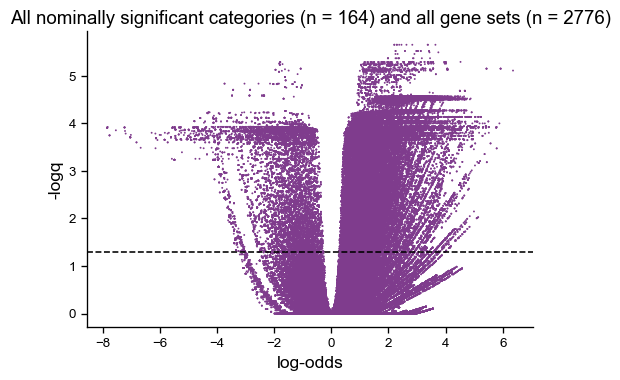

In [29]:
fig, ax = plt.subplots(1, figsize=(6, 4))
sns.scatterplot(
    x=np.log2(combined_gse_results["odds_ratio_cat_baseline"][::2]),
    y=-np.log10(combined_gse_results["fdr_p_cat_baseline"][::2]),
    ec=None,
    s=2,
)
sns.despine(ax=ax)
ax.axhline(y=-np.log10(0.05), linestyle="dashed", color="black")
ax.set_xlabel("log-odds")
ax.set_ylabel("-logq")
ax.set_title(
   f"All nominally significant categories (n = 164) and all gene sets (n = {len(gene_sets)})"
)
fig.savefig("images/baseline-category-enrichment-all.png", bbox_inches="tight")

## Compare the binary genes vs. full counts

We used two approaches--one that binarized genes impacted by SVs and another that actually used counts. I want to compare these two.

In [30]:
binary = combined_gse_results.iloc[::2, :]
full = combined_gse_results.iloc[1::2, :]

In [31]:
binary.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,binary,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/1495,1/103,1,3.614078,0.413876,1.0,957.709515,26/4449,1/523,1,0.626585,0.354281,1.0,819.80628,3/467,1/52,1,4.471154,0.345309,1.0,799.045034,0.005566,0.009091,0.458794,1.0,1061.649048,1,0.005566,0.001634,0.275062,1.0,636.493777,1,0.005566,0.018868,0.256075,1.0,592.556975,1,199/19092,27/4851,0.457816,0.000054,0.000246,0.332482,False,ANY,NaN
2,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,binary,MSigDB_Hallmark_2020,Hypoxia,8/1495,0/103,0,1.589744,1.000000,1.0,2314.000000,34/4449,4/523,4,1.213187,1.000000,1.0,2314.00000,2/467,0/52,0,2.930818,1.000000,1.0,2314.000000,0.006803,0.000000,1.000000,1.0,2314.000000,0,0.006803,0.008170,0.617282,1.0,1428.390075,4,0.006803,0.000000,1.000000,1.0,2314.000000,0,200/19092,33/4851,0.577229,0.003174,0.007934,0.332482,False,ANY,NaN


We care about cases, so let's see what happens to the odds-ratios usually

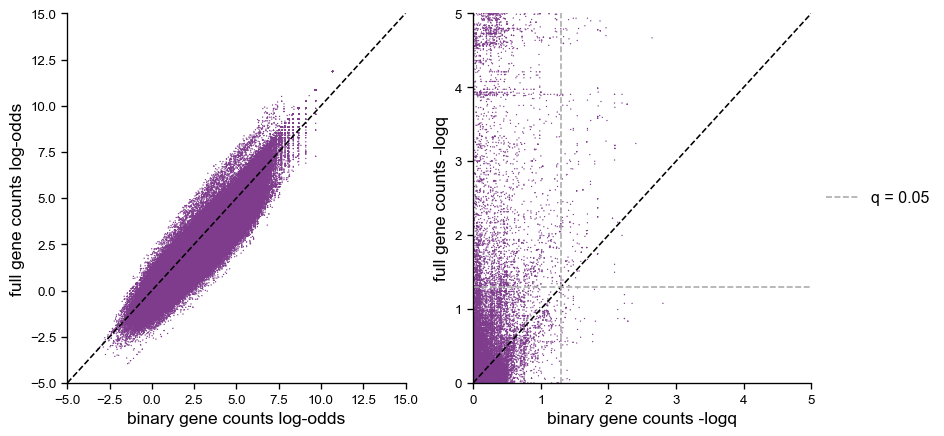

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, col in enumerate(["odds_ratio_cases_fisher", "fdr_p_cases_fisher"]):

    ax = axes[i]

    data_binary = binary[col].values
    data_full = full[col].values

    if col == "odds_ratio_cases_fisher":
        data_binary = np.log2(data_binary)
        data_full = np.log2(data_full)
    else:
        data_binary = -np.log10(data_binary)
        data_full = -np.log10(data_full)

    sns.scatterplot(x=data_binary, y=data_full, ec=None, s=1, ax=ax)

    lim = [-5, 15] if col == "odds_ratio_cases_fisher" else [0, 5]
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.plot(lim, lim, linestyle="dashed", color="black")

    label = ["log-odds", "-logq"][i]
    ax.set_xlabel("binary gene counts " + label)
    ax.set_ylabel("full gene counts " + label)
    sns.despine(ax=ax)

    if col == "fdr_p_cases_fisher":
        ax.axhline(
            -np.log10(0.05), color="darkgrey", linestyle="dashed", label="q = 0.05"
        )
        ax.axvline(-np.log10(0.05), color="darkgrey", linestyle="dashed")
        ax.legend(bbox_to_anchor=(1, 0.5))

fig.savefig(
    "images/binary-vs-full-gene-counts-gse-log-odds-logq.png", bbox_inches="tight"
)

So we can see that while the use of full counts doesn't have a _dramatic_ impact on odds-ratio (on average), it has a _substantial_ impact on p-value. This makes sense because full counts give more power.

I've come to the conclusion that should we use one of these, it should just be the full gene counts. But I don't think we actually care about these.

## Compare enrichment based on genomic overlap and SV counts

In [33]:
full.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,27/3629,1/110,1,2.339610,0.567939,1.0,1314.211961,209/24559,1/612,1,0.378945,0.068291,0.380783,158.025467,3/559,1/53,1,5.254717,0.304598,1.0,704.838667,0.005566,0.009091,0.458794,1.0,1061.649048,1,0.005566,0.001634,0.275062,1.0,636.493777,1,0.005566,0.018868,0.256075,1.0,592.556975,1,199/19092,27/4851,0.457816,0.000054,0.000246,0.332482,False,ANY,NaN
3,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Hypoxia,27/3629,0/110,0,1.159266,1.000000,1.0,2314.000000,238/24559,5/612,4,1.004267,1.000000,1.000000,2314.000000,2/559,0/53,0,3.444444,1.000000,1.0,2314.000000,0.006803,0.000000,1.000000,1.0,2314.000000,0,0.006803,0.008170,0.617282,1.0,1428.390075,4,0.006803,0.000000,1.000000,1.0,2314.000000,0,200/19092,33/4851,0.577229,0.003174,0.007934,0.332482,False,ANY,NaN


/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  


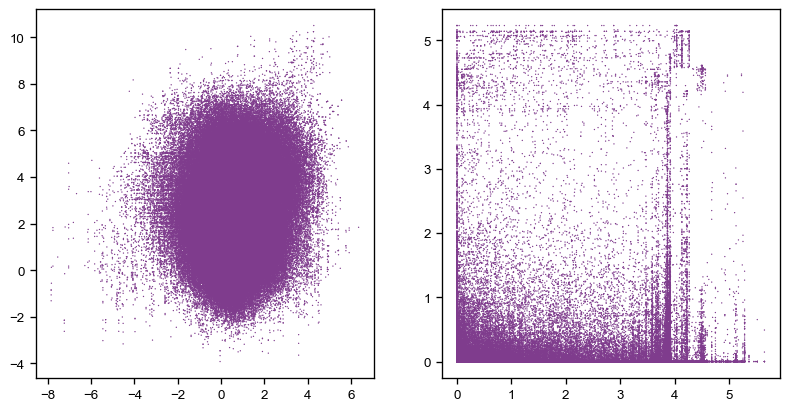

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, (count_col, overlap_col) in enumerate(
    [
        ["odds_ratio_cases_fisher", "odds_ratio_cat_baseline"],
        ["fdr_p_cases_fisher", "fdr_p_cat_baseline"],
    ]
):

    ax = axes[i]

    data_overlap = full[overlap_col].values
    data_full = full[count_col].values

    if count_col == "odds_ratio_cases_fisher":
        data_overlap = np.log2(data_overlap)
        data_full = np.log2(data_full)
    else:
        data_overlap = -np.log10(data_overlap)
        data_full = -np.log10(data_full)

    sns.scatterplot(x=data_overlap, y=data_full, ec=None, s=1, ax=ax)

## Examine category baseline vs. binomial test

This is what I think we _actually_ care about.

In [35]:
combined_gse_results.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category
0,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,binary,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,7/1495,1/103,1,3.614078,0.413876,1.0,957.709515,26/4449,1/523,1,0.626585,0.354281,1.000000,819.806280,3/467,1/52,1,4.471154,0.345309,1.0,799.045034,0.005566,0.009091,0.458794,1.0,1061.649048,1,0.005566,0.001634,0.275062,1.0,636.493777,1,0.005566,0.018868,0.256075,1.0,592.556975,1,199/19092,27/4851,0.457816,0.000054,0.000246,0.332482,False,ANY,NaN
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,27/3629,1/110,1,2.339610,0.567939,1.0,1314.211961,209/24559,1/612,1,0.378945,0.068291,0.380783,158.025467,3/559,1/53,1,5.254717,0.304598,1.0,704.838667,0.005566,0.009091,0.458794,1.0,1061.649048,1,0.005566,0.001634,0.275062,1.0,636.493777,1,0.005566,0.018868,0.256075,1.0,592.556975,1,199/19092,27/4851,0.457816,0.000054,0.000246,0.332482,False,ANY,NaN


In [36]:
combined_gse_results_full = combined_gse_results[
    combined_gse_results["analysis_fisher"] == "full"
]

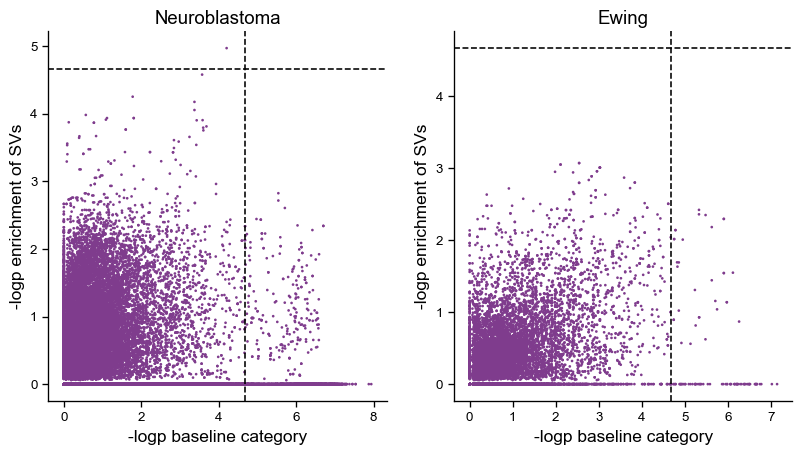

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, disease in enumerate(["neuroblastoma", "ewing"]):

    ax = axes[i]

    sns.scatterplot(
        x=-np.log10(
            combined_gse_results_full.query(f'disease == "{disease}"')["p_cases_fisher"]
        ),
        y=-np.log10(
            combined_gse_results_full.query(f'disease == "{disease}"')[
                "p_cases_unique_binom"
            ]
        ),
        ec=None,
        s=4,
        ax=ax,
    )

    sns.despine(ax=ax)
    ax.axhline(
        y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="black"
    )
    ax.axvline(
        x=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="black"
    )
    ax.set_xlabel("-logp baseline category")
    ax.set_ylabel("-logp enrichment of SVs")
    ax.set_title(disease.capitalize())
    # fig.savefig("images/baseline-category-enrichment-all.png", bbox_inches="tight")

# Analyze most stringent results

We apply a handful of filters:

* Single gene SVs
* Remove genes in controls for within-category (don’t do this in baseline, because control signal already controlled by examining nominal cats)
* p_controls_binomial > 0.05 (no within-category control enrichment)
* At least two genes affected (for within and baseline)

In [38]:
# filter out signals in control, ensure a minimum gene overlap, and use the full fishers test
stringent_results = combined_gse_results.query(
    "p_controls_binom > 0.05 & analysis_fisher == 'full'"
)

In [39]:
stringent_results.head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category
1,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,TNF-alpha Signaling via NF-kB,27/3629,1/110,1,2.339610,0.567939,1.0,1314.211961,209/24559,1/612,1,0.378945,0.068291,0.380783,158.025467,3/559,1/53,1,5.254717,0.304598,1.0,704.838667,0.005566,0.009091,0.458794,1.0,1061.649048,1,0.005566,0.001634,0.275062,1.0,636.493777,1,0.005566,0.018868,0.256075,1.0,592.556975,1,199/19092,27/4851,0.457816,0.000054,0.000246,0.332482,False,ANY,NaN
3,neuroblastoma,DEL.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,MSigDB_Hallmark_2020,Hypoxia,27/3629,0/110,0,1.159266,1.000000,1.0,2314.000000,238/24559,5/612,4,1.004267,1.000000,1.000000,2314.000000,2/559,0/53,0,3.444444,1.000000,1.0,2314.000000,0.006803,0.000000,1.000000,1.0,2314.000000,0,0.006803,0.008170,0.617282,1.0,1428.390075,4,0.006803,0.000000,1.000000,1.0,2314.000000,0,200/19092,33/4851,0.577229,0.003174,0.007934,0.332482,False,ANY,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


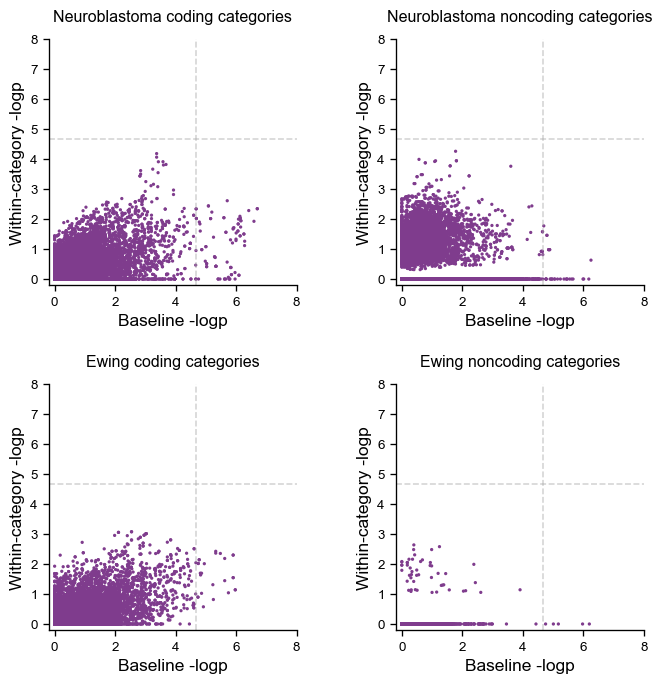

In [41]:
fig, axes = plt.subplots(
    2, 2, figsize=(8, 8), gridspec_kw={"hspace": 0.4, "wspace": 0.4}
)
for i, disease in enumerate(["neuroblastoma", "ewing"]):
    for j, sv_category in enumerate(["coding", "noncoding"]):

        ax = axes[i, j]

        data = stringent_results[
            (stringent_results["disease"] == disease)
            & (stringent_results["sv_category"] == sv_category)
        ].copy()

        data["x"] = -np.log10(data["p_cases_fisher"])
        data["y"] = -np.log10(data["p_cases_unique_binom"])

        data = data.dropna(subset=["x", "y"])

        sns.scatterplot(x = 'x', y = 'y', data = data, 
                        ax = ax, s = 6, ec=None)
        
        ax.legend().remove()

        ax.set_xlim([-0.2, 8])
        ax.set_ylim([-0.2, 8])
        ax.set_xlabel("Baseline -logp")
        ax.set_ylabel("Within-category -logp")
        ax.axvline(
            x=-np.log10(0.05 / num_effective_tests),
            color="darkgrey",
            linestyle="dashed",
            alpha=0.5,
        )
        ax.axhline(
            y=-np.log10(0.05 / num_effective_tests),
            color="darkgrey",
            linestyle="dashed",
            alpha=0.5,
        )
        ax.set_title(
            disease.capitalize() + f" {sv_category} categories", fontsize=12, y=1.04
        )

        sns.despine()

fig.savefig(
    f"images/separating-influences-cwas-gene-set-enrichment-coding.png",
    bbox_inches="tight",
)

# Dig into these results

## Neuroblastoma coding

### Within category enrichment

In [42]:
nbl_coding = combined_gse_results.query(
    'disease == "neuroblastoma" & sv_category == "coding" & analysis_fisher == "full"'
)
nbl_coding = nbl_coding.query("p_controls_binom > 0.05")

nbl_coding['hue_within'] = np.where(nbl_coding['num_unique_genes_in_overlap_cases_unique_binom'] > 1, '≥ 2', '1')
palette = {'≥ 2': Bold_10[0], '1': 'darkgrey'}

nbl_coding["binom_odds_ratio"] = (
    nbl_coding["observed_prop_cases_binom"] / nbl_coding["observed_prop_controls_binom"]
)

nbl_coding["x_within"] = np.log2(nbl_coding["binom_odds_ratio"])
nbl_coding["y_within"] = -np.log10(nbl_coding["p_cases_unique_binom"])

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


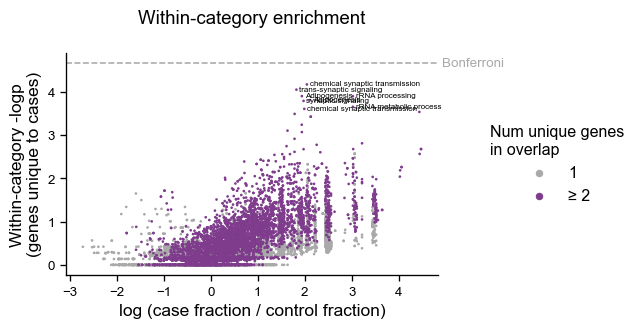

In [44]:
fig, ax = plt.subplots(1, figsize=(5, 3))

data = nbl_coding.query('num_unique_genes_in_overlap_cases_unique_binom > 0')
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_within',
        y='y_within',
        hue = 'hue_within',
        data = data[data['hue_within'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )

ax.legend(bbox_to_anchor = (1.1, 0.5), title = 'Num unique genes\nin overlap', title_fontsize = 12)
    
seen_ps = []
seen_or = []
for i, row in (
    data.sort_values(by="p_cases_unique_binom").reset_index().iterrows()
):

    x = row["x_within"]
    y = row["y_within"]

    if y in seen_ps and x in seen_or:
        continue
    else:
        s = row["gs"]
        if " (" in s:
            s = s[: s.index(" (")]

        ax.text(x=x + 0.06, y=y + 0.02, s=s, fontsize=6, ha="left", va="center")
        seen_ps.append(y)
        seen_or.append(x)

    if len(seen_ps) > 7:
        break

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
sns.despine(ax=ax)
ax.set_xlabel("log (case fraction / control fraction)")
ax.set_ylabel("Within-category -logp\n(genes unique to cases)")
ax.set_title("Within-category enrichment", y=1.1)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)

fig.savefig("images/nbl-coding-within-category.png", bbox_inches="tight")

In [45]:
num_effective_tests

2314

What are the categories that have synaptic transmission signal?

In [46]:
nbl_coding.sort_values(by="fdr_p_cases_unique_binom").head(10)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within
56791,neuroblastoma,ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,rRNA processing (GO:0006364),20/3594,6/145,6,8.511905,0.000371,0.105434,0.859042,128/24384,4/787,4,1.199227,1.000000,1.000000,2314.000000,6/543,6/69,6,8.406250,0.000889,1.000000,2.058289,0.011132,0.041379,0.005953,0.403061,13.775217,6,0.011132,0.005083,0.123938,0.985233,286.792515,4,0.011132,0.086957,0.000125,0.115824,0.289643,6,212/19092,54/4851,1.003372,1.000000,1.000000,0.319513,True,ANY,NaN,≥ 2,8.141379,3.025273,3.902500
39295,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,trans-synaptic signaling (GO:0099537),48/3586,9/153,9,4.980999,0.000424,0.036117,0.980691,267/24329,14/842,12,1.624620,0.130636,0.281339,302.291921,9/524,8/88,8,5.733333,0.001087,0.616388,2.515994,0.015992,0.058824,0.000866,0.244085,2.003552,9,0.015992,0.016627,0.784206,1.000000,1814.651798,12,0.015992,0.090909,0.000088,0.122448,0.204139,8,435/19092,152/9505,0.534289,0.000005,0.000125,0.311639,True,expressed_in_adrenal_gland,NaN,≥ 2,3.537815,1.822859,4.054438
39027,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,chemical synaptic transmission (GO:0007268),48/3586,9/153,9,4.980999,0.000424,0.036117,0.980691,264/24329,12/842,10,1.420693,0.313138,0.513147,724.600609,9/524,8/88,8,5.733333,0.001087,0.616388,2.515994,0.015360,0.058824,0.000653,0.244085,1.511955,9,0.015360,0.014252,1.000000,1.000000,2314.000000,10,0.015360,0.090909,0.000067,0.122448,0.154691,8,418/19092,146/9505,0.534241,0.000004,0.000125,0.311639,True,expressed_in_adrenal_gland,NaN,≥ 2,4.127451,2.045251,4.174899
39603,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,synaptic signaling (GO:0099536),55/3586,10/153,10,4.817956,0.000252,0.031125,0.583337,333/24329,14/842,12,1.300012,0.450408,0.656279,1042.244227,10/524,8/88,8,5.202020,0.001728,0.616388,3.997491,0.017464,0.065359,0.000394,0.186162,0.910648,10,0.017464,0.016627,1.000000,1.000000,2314.000000,12,0.017464,0.090909,0.000161,0.148789,0.372079,8,464/19092,166/9505,0.554065,0.000005,0.000125,0.311639,True,expressed_in_adrenal_gland,NaN,≥ 2,3.930906,1.974862,3.793728
57535,neuroblastoma,ANY.SINGLETON.ANY.unconstrained.ANY.protein_coding,coding,full,GO_Biological_Process_Full,rRNA metabolic process (GO:0016072),22/3594,6/145,6,7.767391,0.000570,0.114794,1.318305,133/24384,4/787,4,1.154242,1.000000,1.000000,2314.00000

Let's look at what genes are actually implicated in these processes. We'll start with adipogenesis:

In [58]:
synaptic_genes = sorted(set(gene_sets["GO_Biological_Process_Full | trans-synaptic signaling (GO:0099537)"]))

test_cat_svs = category_svs[
    (category_svs["category"] == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding")
    & (category_svs["disease"] == "neuroblastoma")
]["SV"].tolist()

case_counts = ref_counts.query(
    'disease == "neuroblastoma" & sv_category == "coding" & cohort == "case" & dose > 0'
)
res = case_counts[
    (case_counts["name"].isin(test_cat_svs)) & (case_counts["gene"].isin(synaptic_genes))
]
res

,name,dose,gene,disease,sv_category,cohort
59,PedSV.2.5.2_DEL_chr1_833,1,TPRG1L,neuroblastoma,coding,case
567,PedSV.2.5.2_DEL_chr1_9923,1,ANXA9,neuroblastoma,coding,case
1627,PedSV.2.5.2_CPX_chr3_36,1,SYN2,neuroblastoma,coding,case
3722,PedSV.2.5.2_CPX_chr7_298,1,EXOC4,neuroblastoma,coding,case
3748,PedSV.2.5.2_CPX_chr7_314,1,BRAF,neuroblastoma,coding,case
4979,PedSV.2.5.2_DEL_chr11_520,1,TH,neuroblastoma,coding,case
5071,PedSV.2.5.2_DEL_chr11_1031,1,RIC3,neuroblastoma,coding,case
5298,PedSV.2.5.2_DEL_chr11_5861,1,FCHSD2,neuroblastoma,coding,case
5839,PedSV.2.5.2_CPX_chr12_199,1,P2RX4,neuroblastoma,coding,case
6476,PedSV.2.5.2_DEL_chr15_945,1,GJD2,neuroblastoma,coding,case


In [59]:
for index, row in res.iterrows():
    print(row["gene"], end=", ")

TPRG1L, ANXA9, SYN2, EXOC4, BRAF, TH, RIC3, FCHSD2, P2RX4, GJD2, TRPV1, SYNJ1, LARGE1, 

In [60]:
synaptic_signaling_gs = [
    "GO_Biological_Process_Full | trans-synaptic signaling (GO:0099537)",
    "GO_Biological_Process_Full | chemical synaptic transmission (GO:0007268)",
    "GO_Biological_Process_Full | synaptic signaling (GO:0099536)",
]

synaptic_signaling_genes = sorted(
    set([g for gs in synaptic_signaling_gs for g in gene_sets[gs]])
)

test_cat_svs = category_svs[
    (
        category_svs["category"]
        == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding"
    )
    & (category_svs["disease"] == "neuroblastoma")
]["SV"].tolist()

case_counts = ref_counts.query(
    'disease == "neuroblastoma" & sv_category == "coding" & cohort == "case_unique" & dose > 0'
)
res = case_counts[
    (case_counts["name"].isin(test_cat_svs))
    & (case_counts["gene"].isin(synaptic_signaling_genes))
]
res

,name,dose,gene,disease,sv_category,cohort
19904,PedSV.2.5.2_DEL_chr1_833,1,TPRG1L,neuroblastoma,coding,case_unique
19983,PedSV.2.5.2_DEL_chr1_9923,1,ANXA9,neuroblastoma,coding,case_unique
20173,PedSV.2.5.2_CPX_chr3_36,1,SYN2,neuroblastoma,coding,case_unique
20533,PedSV.2.5.2_CPX_chr7_314,1,BRAF,neuroblastoma,coding,case_unique
20748,PedSV.2.5.2_DEL_chr11_520,1,TH,neuroblastoma,coding,case_unique
20762,PedSV.2.5.2_DEL_chr11_1031,1,RIC3,neuroblastoma,coding,case_unique
20809,PedSV.2.5.2_DEL_chr11_5861,1,FCHSD2,neuroblastoma,coding,case_unique
20888,PedSV.2.5.2_CPX_chr12_199,1,P2RX4,neuroblastoma,coding,case_unique
21344,PedSV.2.5.2_INS_chr21_813,1,SYNJ1,neuroblastoma,coding,case_unique
21369,PedSV.2.5.2_DEL_chr22_1874,1,LARGE1,neuroblastoma,coding,case_unique


And what about baseline category enrichment?

### Baseline enrichment

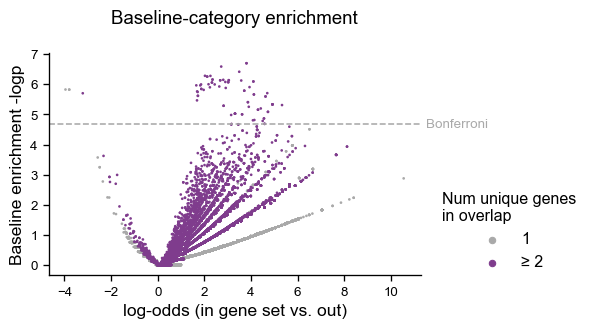

In [61]:
fig, ax = plt.subplots(1, figsize=(5, 3))

nbl_coding["x_baseline"] = np.log2(nbl_coding["odds_ratio_cases_fisher"])
nbl_coding["y_baseline"] = -np.log10(nbl_coding["p_cases_fisher"])
nbl_coding['hue_baseline'] = np.where(nbl_coding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = nbl_coding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend(bbox_to_anchor = (1.02, 0.2), title = 'Num unique genes\nin overlap', title_fontsize = 12)

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/nbl-coding-baseline-category.png", bbox_inches="tight")

In [62]:
test = nbl_coding.query("p_cases_fisher < 0.05 / 2314").drop_duplicates(
    subset=["p_cases_fisher", "odds_ratio_cases_fisher"]
).sort_values(by="p_cases_fisher")[['category', 'gs', 'p_cases_fisher', 'odds_ratio_cases_fisher']]
test['-logp'] = -np.log10(test['p_cases_fisher'])
test['log-odds'] = -np.log2(test['odds_ratio_cases_fisher'])
test.head(8)

,category,gs,p_cases_fisher,odds_ratio_cases_fisher,-logp,log-odds
8269,DEL.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,forebrain development (GO:0030900),1.990620e-07,13.982439,6.701012,-3.805544
63499,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,head development (GO:0060322),2.566778e-07,6.597452,6.590612,-2.721909
63769,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,forebrain development (GO:0030900),3.816362e-07,11.266667,6.418350,-3.493989
69049,ANY.SINGLETON.ANY.ANY.ANY.protein_coding,head development (GO:0060322),5.202369e-07,4.069463,6.283799,-2.024838
64831,ANY.SINGLETON.ANY.ANY.expressed_in_adrenal_gland.protein_coding,central nervous system development (GO:0007417),5.240877e-07,4.785276,6.280596,-2.258602
14881,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,central nervous system development (GO:0007417),5.523475e-07,4.346281,6.257788,-2.119781
13531,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,brain development (GO:0007420),6.935412e-07,5.093080,6.158928,-2.348538
41281,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,brain development (GO:0007420),7.074705e-07,7.011281,6.150292,-2.809678


In [63]:
# nbl_coding.sort_values(by = 'fdr_p_cases_unique_binom').head(20)

What genes are actually being detected with this whole brain development stuff?

In [64]:
baseline_significant = nbl_coding.query("p_cases_fisher < 0.05 / 2314").sort_values(
    by="p_cases_fisher"
)

neuro_related = [
    "GO_Biological_Process_Full | brain development (GO:0007420)",
    "GO_Biological_Process_Full | head development (GO:0060322)",
    "GO_Biological_Process_Full | forebrain development (GO:0030900)",
    "GO_Biological_Process_Full | telencephalon development (GO:0021537)",
    "GO_Biological_Process_Full | central nervous system development (GO:0007417)"
]

adipo_related = [
    "MSigDB_Hallmark_2020 | Adipogenesis"
]

neuro_related_genes = sorted(set([g for gs in neuro_related for g in gene_sets[gs]]))
adipo_related_genes = sorted(set([g for gs in adipo_related for g in gene_sets[gs]]))

I want to take a mega biased look at just look at dosages in these genes for some large categories.

In [65]:
for i, gene_group in enumerate(
    [neuro_related_genes, adipo_related_genes]
):
    test_cat = "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding"

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "neuroblastoma")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "coding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_neuro_dosage = case_counts[case_counts["gene"].isin(gene_group)]["dose"].sum()

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "coding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_neuro_dosage = control_counts[control_counts["gene"].isin(gene_group)][
        "dose"
    ].sum()

    print(case_neuro_dosage, case_dosage, control_neuro_dosage, control_dosage)

23 246 58 1288
9 246 19 1288


In [66]:
cat_genes = category_gene_matrix.loc[
    "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding"
]
cat_genes = list(cat_genes[cat_genes == 1].index)
print(len(cat_genes), len(set(cat_genes) & set(neuro_related_genes)))
print(len(cat_genes), len(set(cat_genes) & set(adipo_related_genes)))

# also check the overlap between synapse and neuro genes
print(
    len(synaptic_signaling_genes),
    len(set(synaptic_signaling_genes) & set(neuro_related_genes)),
)

9505 532
9505 179
464 73


In [67]:
len(set(neuro_related_genes) & set(adipo_related_genes))

11

In [69]:
print(532 / 9505, 23 / 246, 58 / 1288)
print(179 / 9505, 7 / 157, 15 / 864)

0.055970541820094685 0.09349593495934959 0.04503105590062112
0.01883219358232509 0.044585987261146494 0.017361111111111112


In [70]:
nbl_coding.query('category == "ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding" & gs == "trans-synaptic signaling (GO:0099537)"')

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
39295,neuroblastoma,ANY.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_adrenal_gland.protein_coding,coding,full,GO_Biological_Process_Full,trans-synaptic signaling (GO:0099537),48/3586,9/153,9,4.980999,0.000424,0.036117,0.980691,267/24329,14/842,12,1.62462,0.130636,0.281339,302.291921,9/524,8/88,8,5.733333,0.001087,0.616388,2.515994,0.015992,0.058824,0.000866,0.244085,2.003552,9,0.015992,0.016627,0.784206,1.0,1814.651798,12,0.015992,0.090909,0.000088,0.122448,0.204139,8,435/19092,152/9505,0.534289,0.000005,0.000125,0.311639,True,expressed_in_adrenal_gland,NaN,≥ 2,3.537815,1.822859,4.054438,2.316435,3.372831,≥ 2


## Neuroblastoma non-coding

### Within category enrichment

In [71]:
nbl_noncoding = combined_gse_results.query(
    'disease == "neuroblastoma" & sv_category == "noncoding" & analysis_fisher == "full"'
)
nbl_noncoding = nbl_noncoding.query("p_controls_binom > 0.05")

nbl_noncoding['hue_within'] = np.where(nbl_noncoding['num_unique_genes_in_overlap_cases_unique_binom'] > 1, '≥ 2', '1')
palette = {'≥ 2': Bold_10[0], '1': 'darkgrey'}

nbl_noncoding["binom_odds_ratio"] = (
    nbl_noncoding["observed_prop_cases_binom"] / nbl_noncoding["observed_prop_controls_binom"]
)

nbl_noncoding["x_within"] = np.log2(nbl_noncoding["binom_odds_ratio"])
nbl_noncoding["y_within"] = -np.log10(nbl_noncoding["p_cases_unique_binom"])

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


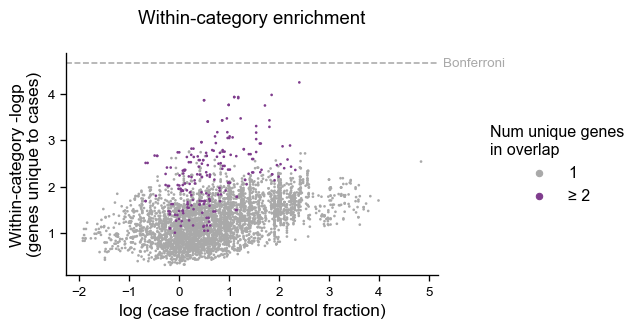

In [72]:
fig, ax = plt.subplots(1, figsize=(5, 3))

data = nbl_noncoding.query('num_unique_genes_in_overlap_cases_unique_binom > 0').copy()
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_within',
        y='y_within',
        hue = 'hue_within',
        data = data[data['hue_within'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )

ax.legend(bbox_to_anchor = (1.1, 0.5), title = 'Num unique genes\nin overlap', title_fontsize = 12)
    
# seen_ps = []
# seen_or = []
# for i, row in (
#     nbl_noncoding.sort_values(by="p_cases_unique_binom").reset_index().iterrows()
# ):

#     x = row["x_within"]
#     y = row["y_within"]

#     if y in seen_ps and x in seen_or:
#         continue
#     else:
#         s = row["gs"]
#         if " (" in s:
#             s = s[: s.index(" (")]

#         ax.text(x=x + 0.06, y=y + 0.02, s=s, fontsize=6, ha="left", va="center")
#         seen_ps.append(y)
#         seen_or.append(x)

#     if len(seen_ps) > 3:
#         break

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
sns.despine(ax=ax)
ax.set_xlabel("log (case fraction / control fraction)")
ax.set_ylabel("Within-category -logp\n(genes unique to cases)")
ax.set_title("Within-category enrichment", y=1.1)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)

fig.savefig("images/nbl-noncoding-within-category.png", bbox_inches="tight")

In [73]:
nbl_noncoding.sort_values(by = 'y_within', ascending = False) \
    [['category', 'gs', 'p_cases_unique_binom', 'binom_odds_ratio', 'x_within', 'y_within', 'num_unique_genes_in_overlap_cases_unique_binom']].head(10)

,category,gs,p_cases_unique_binom,binom_odds_ratio,x_within,y_within,num_unique_genes_in_overlap_cases_unique_binom
303809,DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,dopamine receptor signaling pathway (GO:0007212),0.000056,5.309917,2.408689,4.251789,2
675659,DEL.RARE.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,dopamine receptor signaling pathway (GO:0007212),0.000104,3.615347,1.854134,3.981844,2
304897,DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,cellular response to dopamine (GO:1903351),0.000116,2.275679,1.186297,3.936052,2
385465,DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding,cell-cell signaling by wnt (GO:0198738),0.000116,2.151976,1.105662,3.935427,3
387135,DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding,Wnt signaling pathway (GO:0016055),0.000116,2.151976,1.105662,3.935427,3
304651,DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,response to dopamine (GO:1903350),0.000122,2.275679,1.186297,3.912344,2
303885,DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,Wnt signaling pathway (GO:0016055),0.000136,1.415978,0.501799,3.866786,3
302215,DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding,cell-cell signaling by wnt (GO:0198738),0.000136,1.415978,0.501799,3.866786,3
346615,DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak_conserved.ANY.ANY.ANY.protein_coding,cell-cell signaling by wnt (GO:0198738),0.000171,1.992661,0.994696,3.765844,3
348285,DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak_conserved.ANY.ANY.ANY.protein_coding,Wnt signaling pathway (GO:0016055),0.000171,1.992661,0.994696,3.765844,3


In [74]:
dopamine = ('DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding', 
            'GO_Biological_Process_Full | dopamine receptor signaling pathway (GO:0007212)')

wnt = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
       'GO_Biological_Process_Full | Wnt signaling pathway (GO:0016055)')

wnt2 = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
        'GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)')

protein_folding = ('DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding', 
                   'GO_Biological_Process_Full | protein folding (GO:0006457)')

I want to take a mega biased look at just look at dosages in these genes for some large categories.

In [75]:
ref_lookups = {}
for i, gene_group in enumerate(
    [dopamine, wnt, wnt2, protein_folding]
):
    
    test_cat = gene_group[0]
    related_genes = sorted(set(gene_sets[gene_group[1]]))

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "neuroblastoma")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "noncoding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_gs = case_counts[case_counts["gene"].isin(related_genes)]
    case_gs_dosage = case_gs['dose'].sum()
    
    ref_lookups[gene_group[1]] = case_gs

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "noncoding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_gs = control_counts[control_counts["gene"].isin(related_genes)]
    control_gs_dosage = control_gs["dose"].sum()
    
    cat_genes = category_gene_matrix.loc[test_cat]
    cat_genes = list(cat_genes[cat_genes == 1].index)
    
    print(gene_group[0])
    print(gene_group[1])
    print(case_gs_dosage, case_dosage, control_gs_dosage, control_dosage, len(set(cat_genes) & set(related_genes)), len(cat_genes))
    print(case_gs_dosage / case_dosage, control_gs_dosage / control_dosage, len(set(cat_genes) & set(related_genes)) / len(cat_genes))
    
    print(case_gs['gene'].tolist(), control_gs['gene'].tolist())
    print()


DEL.SINGLETON.ANY.neuroblastoma_atac_peaks_conserved.ANY.ANY.ANY.protein_coding
GO_Biological_Process_Full | dopamine receptor signaling pathway (GO:0007212)
3 248 3 1307 25 12905
0.012096774193548387 0.0022953328232593728 0.0019372336303758234
['PTGER1', 'GSK3A', 'GNAS'] ['NSG2', 'SLC1A1', 'SLC1A1']

DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding
GO_Biological_Process_Full | Wnt signaling pathway (GO:0016055)
4 51 7 191 158 6899
0.0784313725490196 0.03664921465968586 0.022901869836208146
['TCF7L2', 'BCL9L', 'HIC1', 'GSK3A'] ['BCL9', 'FZD7', 'AMOTL2', 'SHH', 'RNF43', 'ZNRF3', 'CSNK1E']

DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding
GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)
7 51 8 191 182 6899
0.13725490196078433 0.041884816753926704 0.02638063487461951
['PLPP3', 'TCF7L2', 'ATP6V0C', 'HIC1', 'GSK3A', 'ADNP', 'PRDM15'] ['FZD7', 'SHH', 'MLLT3', 'RNF43', 'CDH2', 'BMP2', 'ZNRF3

In [76]:
intergenic_sv_to_gene_distances = pd.read_csv('data/cwas-results/intergenic-sv-to-gene-distances.csv')

In [77]:
test_dopamine_svs = ref_lookups['GO_Biological_Process_Full | dopamine receptor signaling pathway (GO:0007212)']
test_wnt_svs = ref_lookups['GO_Biological_Process_Full | Wnt signaling pathway (GO:0016055)']
test_dopamine_svs

,name,dose,gene,disease,sv_category,cohort
177107,PedSV.2.5.2_DEL_chr19_2961,1,PTGER1,neuroblastoma,noncoding,case
179043,PedSV.2.5.2_DEL_chr19_5704,1,GSK3A,neuroblastoma,noncoding,case
184804,PedSV.2.5.2_DEL_chr20_4403,1,GNAS,neuroblastoma,noncoding,case


In [78]:
intergenic_sv_to_gene_distances[lambda row: row['name'].isin(test_dopamine_svs['name'].tolist())]

,name,#chrom,start_sv,end_sv,gene_name,start_gene,end_gene,distance
121795,PedSV.2.5.2_DEL_chr19_5704,chr19,42245054,42247555,GSK3A,42226225,42242625,2429


In [79]:
svs[svs['name'].isin(test_dopamine_svs['name'].tolist())]

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR
202902,chr19,14475465,14475516,PedSV.2.5.2_DEL_chr19_2961,DEL,1,0.000074,manta,13458,True,NaN,NaN,NaN,NaN,14475516,NaN,SR,NaN,1.0,0.2,1.0,False,False,NaN,NaN,-53.0,4,0.000213,NaN,0.2,All_20_Batches.chr19.final_cleanup_DEL_chr19_3426,0.000403,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,"neuroblastoma_atac_peaks_conserved,osteosarcoma_chromHMM15_TssAFlnk_conserved",NaN,NaN,PTGER1,NaN,NaN
205424,chr19,42245054,42247555,PedSV.2.5.2_DEL_chr19_5704,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,42247555,NaN,"PE,RD,SR",NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,0,0.000000,NaN,1.0,All_20_Batches.chr19.final_cleanup_DEL_chr19_6555,0.000000,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,GSK3A,"ewing_H3K27Ac_peak_conserved,ewing_and_osteosarcoma_atac_peaks,ewing_chromHMM15_TssAFlnk_unconserved,neuroblastoma_H3K27Ac_peak_conserved,neuroblastoma_atac_peaks,neuroblastoma_chromHMM15_Enh,neur...","ewing_H3K27Ac_peak_conserved,ewing_and_osteosarcoma_atac_peaks_conserved,neuroblastoma_ABC_MAX_enhancer_conserved,neuroblastoma_ABC_MAX_enhancer_unconserved,neuroblastoma_atac_peaks_conserved,neur...",NaN,NaN,NaN,NaN
212522,chr20,58866172,58868001,PedSV.2.5.2_DEL_chr20_4403,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,58868001,NaN,"PE,RD,SR",NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,0,0.000000,NaN,1.0,All_20_Batches.chr20.final_cleanup_DEL_chr20_5088,0.000000,False,NaN,NaN,NaN,False,NaN,GNAS,NaN,NaN,NaN,NaN,"ewing_and_osteosarcoma_tad_boundary,ewing_chromHMM15_Quies,neuroblastoma_chromHMM15_Quies","ewing_and_osteosarcoma_atac_peaks,neuroblastoma_atac_peaks_conserved,osteosarcoma_chromHMM15_EnhBiv_conserved",NaN,NaN,NaN,NaN


In [80]:
intergenic_sv_to_gene_distances[lambda row: row['name'].isin(test_wnt_svs['name'].tolist())]

,name,#chrom,start_sv,end_sv,gene_name,start_gene,end_gene,distance
82169,PedSV.2.5.2_DEL_chr10_7974,chr10,113184882,113188426,TCF7L2,112950247,113167678,17204
112442,PedSV.2.5.2_DEL_chr17_661,chr17,2050553,2050622,HIC1,2054154,2063241,3532
121795,PedSV.2.5.2_DEL_chr19_5704,chr19,42245054,42247555,GSK3A,42226225,42242625,2429


In [81]:
svs[svs['name'].isin(test_wnt_svs['name'].tolist())]

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR
135597,chr10,113184882,113188426,PedSV.2.5.2_DEL_chr10_7974,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,113188426,NaN,"PE,RD,SR",NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,0,0.00000,NaN,1.0,All_20_Batches.chr10.final_cleanup_DEL_chr10_9418,0.000000,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,TCF7L2,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM15_Enh","neuroblastoma_ABC_MAX_enhancer_conserved,neuroblastoma_atac_peaks_conserved",NaN,NaN,NaN,NaN
147050,chr11,118921760,118922956,PedSV.2.5.2_DEL_chr11_8892,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,118922956,NaN,"PE,SR",NaN,1.0,1.0,0.5,False,False,NaN,NaN,-12.0,0,0.00000,NaN,0.5,All_20_Batches.chr11.final_cleanup_DEL_chr11_10522,0.000000,False,NaN,NaN,NaN,False,NaN,BCL9L,NaN,NaN,NaN,NaN,"ewing_H3K27Ac_peak_conserved,ewing_chromHMM15_TssAFlnk_conserved,neuroblastoma_H3K27Ac_peak_conserved,neuroblastoma_atac_peaks_conserved,neuroblastoma_chromHMM15_TssAFlnk_conserved,osteosarcoma_AB...","ewing_and_osteosarcoma_atac_peaks_conserved,neuroblastoma_ABC_MAX_enhancer_conserved,neuroblastoma_atac_peaks_conserved,neuroblastoma_encode_consensus_enhancers_conserved,osteosarcoma_encode_conse...",NaN,NaN,NaN,NaN
187696,chr17,2050553,2050622,PedSV.2.5.2_DEL_chr17_661,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,2050622,NaN,SR,NaN,1.0,0.4,1.0,False,False,NaN,NaN,-53.0,3,0.00032,NaN,0.4,All_20_Batches.chr17.final_cleanup_DEL_chr17_742,0.000302,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,HIC1,"ewing_and_osteosarcoma_atac_peaks_conserved,ewing_and_osteosarcoma_tad_boundary_conserved,neuroblastoma_ABC_MAX_enhancer_conserved,neuroblastoma_H3K27Ac_peak_conserved,neuroblastoma_atac_peaks_con...",NaN,NaN,NaN,NaN,NaN
205424,chr19,42245054,42247555,PedSV.2.5.2_DEL_chr19_5704,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,42247555,NaN,"PE,RD,SR",NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,0,0.00000,NaN,1.0,All_20_Batches.chr19.final_cleanup_DEL_chr19_6555,0.000000,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,GSK3A,"ewing_H3K27Ac_peak_conserved,ewing_and_osteosarcoma_atac_peaks,ewing_chromHMM15_TssAFlnk_unconserved,neuroblastoma_H3K27Ac_peak_conserved,neuroblastoma_atac_peaks,neuroblastoma_chromHMM15_Enh,neur...","ewing_H3K27Ac_peak_conserved,ewing_and_osteosarcoma_atac_peaks_conserved,neuroblastoma_ABC_MAX_enhancer_conserved,neuroblastoma_ABC_MAX_enhancer_unconserved,neuroblastoma_atac_peaks_conserved,neur...",NaN,NaN,NaN,NaN


So these SVs are actually pretty close...

### Baseline enrichment

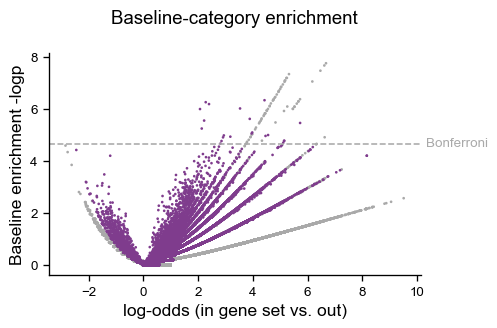

In [83]:
fig, ax = plt.subplots(1, figsize=(5, 3))

nbl_noncoding["x_baseline"] = np.log2(nbl_noncoding["odds_ratio_cases_fisher"])
nbl_noncoding["y_baseline"] = -np.log10(nbl_noncoding["p_cases_fisher"])
nbl_noncoding['hue_baseline'] = np.where(nbl_noncoding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = nbl_noncoding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
data = data[lambda row: ~row['category'].str.contains('cosmic')] 

for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend().remove()

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/nbl-noncoding-baseline-category.png", bbox_inches="tight")

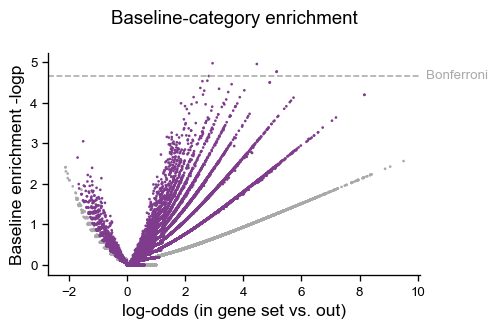

In [84]:
fig, ax = plt.subplots(1, figsize=(5, 3))

nbl_noncoding["x_baseline"] = np.log2(nbl_noncoding["odds_ratio_cases_fisher"])
nbl_noncoding["y_baseline"] = -np.log10(nbl_noncoding["p_cases_fisher"])
nbl_noncoding['hue_baseline'] = np.where(nbl_noncoding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = nbl_noncoding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
data = data[lambda row: ~row['category'].str.contains('cosmic')] 
data = data[lambda row: row['category'].str.contains('SINGLETON')]

for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend().remove()

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/nbl-singleton-noncoding-baseline-category.png", bbox_inches="tight")

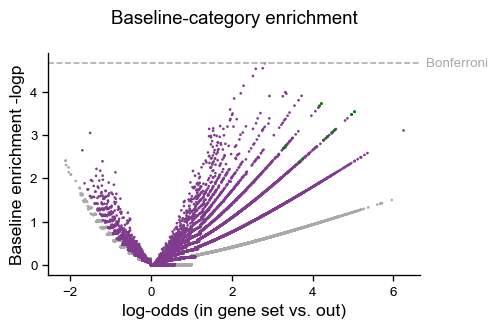

In [85]:
fig, ax = plt.subplots(1, figsize=(5, 3))

nbl_noncoding["x_baseline"] = np.log2(nbl_noncoding["odds_ratio_cases_fisher"])
nbl_noncoding["y_baseline"] = -np.log10(nbl_noncoding["p_cases_fisher"])
nbl_noncoding['hue_baseline'] = np.where(nbl_noncoding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = nbl_noncoding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
data = data[lambda row: ~row['category'].str.contains('cosmic')] 
data = data[lambda row: row['category'].str.contains('SINGLETON')]
data = data[lambda row: row['category'].str.contains('neuroblastoma_tad_boundary')]

for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
    sub = data.query('gs == "vesicle coating (GO:0006901)"')
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        data = sub,
        s=4,
        color = 'green',
        ec=None,
        ax=ax
    )
    
ax.legend().remove()

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/nbl-singleton-noncoding-baseline-category-tads.png", bbox_inches="tight")

In [86]:
data.query('num_unique_genes_in_overlap_cases_fisher > 1').sort_values(by = 'y_baseline', ascending = False).iloc[:20]

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
116601,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,MSigDB_Hallmark_2020,mTORC1 Signaling,939/110754,9/174,8,7.037683,0.000022,0.060541,0.050466,7077/872257,12/917,10,1.753927,0.095851,0.316388,221.799267,1/257,1/9,1,28.555556,0.066648,1.0,154.222897,0.018435,0.051724,0.005310,1.000000,12.288219,8,0.018435,0.013086,0.268705,0.814142,621.782790,10,0.018435,0.111111,0.154189,1.0,356.793564,1,199/19092,61/3309,2.129170,0.000005,0.000028,0.386618,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,3.952586,1.982797,0.811946,2.815100,4.661366,≥ 2
210951,neuroblastoma,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,MSigDB_Hallmark_2020,mTORC1 Signaling,939/110748,9/180,8,6.791811,0.000028,0.079066,0.065907,7077/872202,12/972,10,1.653441,0.148150,0.393142,342.819488,1/257,1/9,1,28.555556,0.066648,1.0,154.222897,0.018435,0.050000,0.006587,1.000000,15.242586,8,0.018435,0.012346,0.188196,0.705943,435.486554,10,0.018435,0.111111,0.154189,1.0,356.793564,1,199/19092,61/3309,2.129170,0.000005,0.000028,0.355521,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,4.050000,2.017922,0.811946,2.763796,4.545432,≥ 2
467405,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,GO_Biological_Process_Full,regulation of translation (GO:0006417),1965/110818,10/110,10,6.030207,0.000029,0.081256,0.067733,15624/872670,22/504,17,2.611953,0.000155,0.005454,0.357622,5/262,0/4,0,8.600000,1.000000,1.0,2314.000000,0.034149,0.090909,0.004537,1.000000,10.498119,10,0.034149,0.043651,0.220694,0.664641,510.685961,17,0.034149,0.000000,1.000000,1.0,2314.000000,0,400/19092,113/3309,1.909015,0.000003,0.000583,0.519762,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,2.082645,1.058417,-0.000000,2.592207,4.533565,≥ 2
201005,neuroblastoma,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,GO_Biological_Process_Full,regulation of translation (GO:0006417),1965/110813,10/115,10,5.745499,0.000043,0.100241,0.099383,15624/872627,22/547,17,2.398308,0.000521,0.009979,1.206124,5/262,0/4,0,8.600000,1.000000,1.0,2314.000000,0.034149,0.086957,0.006193,1.000000,14.330817,10,0.034149,0.040219,0.409167,0.819678,946.812227,17,0.034149,0.000000,1.000000,1.0,2314.000000,0,400/19092,113/3309,1.909015,0.000003,0.000583,0.472905,True,expressed_in_adrenal_gland,neuroblastoma_tad_boun

In [87]:
data.query('num_unique_genes_in_overlap_cases_fisher > 1').sort_values(by = 'y_baseline', ascending = False).head(2)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
116601,neuroblastoma,ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,MSigDB_Hallmark_2020,mTORC1 Signaling,939/110754,9/174,8,7.037683,0.000022,0.060541,0.050466,7077/872257,12/917,10,1.753927,0.095851,0.316388,221.799267,1/257,1/9,1,28.555556,0.066648,1.0,154.222897,0.018435,0.051724,0.005310,1.0,12.288219,8,0.018435,0.013086,0.268705,0.814142,621.782790,10,0.018435,0.111111,0.154189,1.0,356.793564,1,199/19092,61/3309,2.12917,0.000005,0.000028,0.386618,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,3.952586,1.982797,0.811946,2.815100,4.661366,≥ 2
210951,neuroblastoma,ANY.SINGLETON.ANY.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding,noncoding,full,MSigDB_Hallmark_2020,mTORC1 Signaling,939/110748,9/180,8,6.791811,0.000028,0.079066,0.065907,7077/872202,12/972,10,1.653441,0.148150,0.393142,342.819488,1/257,1/9,1,28.555556,0.066648,1.0,154.222897,0.018435,0.050000,0.006587,1.0,15.242586,8,0.018435,0.012346,0.188196,0.705943,435.486554,10,0.018435,0.111111,0.154189,1.0,356.793564,1,199/19092,61/3309,2.12917,0.000005,0.000028,0.355521,True,expressed_in_adrenal_gland,neuroblastoma_tad_boundary,1,4.050000,2.017922,0.811946,2.763796,4.545432,≥ 2


In [88]:
mtorc1 = ('ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding', 
          'MSigDB_Hallmark_2020 | mTORC1 Signaling')

collagen = ('DEL.SINGLETON.ANY.neuroblastoma_H3K27Ac_peak_conserved.ANY.ANY.ANY.protein_coding', 
            'GO_Biological_Process_Full | cellular response to ionizing radiation (GO:0071479)')

# wnt2 = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
#         'GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)')

# protein_folding = ('DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding', 
#                    'GO_Biological_Process_Full | protein folding (GO:0006457)')

I want to take a mega biased look at just look at dosages in these genes for some large categories.

In [89]:
ref_lookups = {}
for i, gene_group in enumerate(
    [mtorc1]
):
    
    test_cat = gene_group[0]
    related_genes = sorted(set(gene_sets[gene_group[1]]))

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "neuroblastoma")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "noncoding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_gs = case_counts[case_counts["gene"].isin(related_genes)]
    case_gs_dosage = case_gs['dose'].sum()
    
    ref_lookups[gene_group[1]] = case_gs

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "neuroblastoma" & sv_category == "noncoding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_gs = control_counts[control_counts["gene"].isin(related_genes)]
    control_gs_dosage = control_gs["dose"].sum()
    
    cat_genes = category_gene_matrix.loc[test_cat]
    cat_genes = list(cat_genes[cat_genes == 1].index)
    
    print(gene_group[0])
    print(gene_group[1])
    print(case_gs_dosage, case_dosage, control_gs_dosage, control_dosage, len(set(cat_genes) & set(related_genes)), len(cat_genes))
    print(case_gs_dosage / case_dosage, control_gs_dosage / control_dosage, len(set(cat_genes) & set(related_genes)) / len(cat_genes))
    
    print(case_gs['gene'].tolist(), control_gs['gene'].tolist())
    print()


ANY.SINGLETON.PREDICTED_NONCODING_BREAKPOINT.neuroblastoma_tad_boundary.ANY.ANY.expressed_in_adrenal_gland.protein_coding
MSigDB_Hallmark_2020 | mTORC1 Signaling
9 174 12 925 61 3309
0.05172413793103448 0.012972972972972972 0.018434572378362043
['ENO1', 'ENO1', 'SLC1A4', 'SERP1', 'SSR1', 'TES', 'PSMA4', 'RPA1', 'XBP1'] ['ENO1', 'ENO1', 'SLC1A4', 'SLC1A4', 'SERP1', 'ELOVL6', 'GLRX', 'GCLC', 'YKT6', 'CYP51A1', 'NUP205', 'RPA1']



In [90]:
for thing in case_gs['gene']:
    print(thing, end = ', ')

ENO1, ENO1, SLC1A4, SERP1, SSR1, TES, PSMA4, RPA1, XBP1, 

In [91]:
test_tad_svs = case_gs[~case_gs['gene'].isin(control_gs['gene'].tolist())]
test_tad_svs

,name,dose,gene,disease,sv_category,cohort
82687,PedSV.2.5.2_DEL_chr6_599,1,SSR1,neuroblastoma,noncoding,case
100190,PedSV.2.5.2_DEL_chr7_9454,1,TES,neuroblastoma,noncoding,case
158074,PedSV.2.5.2_INS_chr15_1766,1,PSMA4,neuroblastoma,noncoding,case
188330,PedSV.2.5.2_DEL_chr22_1485,1,XBP1,neuroblastoma,noncoding,case


In [92]:
svs[svs['name'].isin(test_tad_svs['name'].tolist())]

,#chrom,start,end,name,svtype,AC,AF,ALGORITHMS,AN,BOTHSIDES_SUPPORT,CHR2,CNV_CONCORDANCE,CPX_INTERVALS,CPX_TYPE,END,END2,EVIDENCE,FAILED_COHORT_COMPARISONS,GENOTYPE_CONCORDANCE,HET_PPV,HET_SENSITIVITY,HG38_REF_PATCH_LOCUS,HIGH_SR_BACKGROUND,HOMVAR_PPV,HOMVAR_SENSITIVITY,MINSL,NCN,NCR,NCR_TMP,NON_REF_GENOTYPE_CONCORDANCE,OLD_ID,PCRMINUS_NCR,PESR_GT_OVERDISPERSION,PREDICTED_BREAKEND_EXONIC,PREDICTED_COPY_GAIN,PREDICTED_DUP_PARTIAL,PREDICTED_INTERGENIC,PREDICTED_INTRAGENIC_EXON_DUP,PREDICTED_INTRONIC,PREDICTED_INV_SPAN,PREDICTED_LOF,PREDICTED_MSV_EXON_OVERLAP,PREDICTED_NEAREST_TSS,PREDICTED_NONCODING_BREAKPOINT,PREDICTED_NONCODING_SPAN,PREDICTED_PARTIAL_EXON_DUP,PREDICTED_PROMOTER,PREDICTED_TSS_DUP,PREDICTED_UTR
79631,chr6,7274000,7280001,PedSV.2.5.2_DEL_chr6_599,DEL,1,0.000077,depth,13028,False,NaN,NaN,NaN,NaN,7280001,NaN,RD,NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,51,0.029754,NaN,1.0,All_20_Batches.chr6.final_cleanup_DEL_chr6_671,0.005134,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,SSR1,"ewing_chromHMM15_Quies,neuroblastoma_tad_boundary,osteosarcoma_chromHMM15_Quies","ewing_and_osteosarcoma_atac_peaks,ewing_and_osteosarcoma_atac_peaks_unconserved,neuroblastoma_atac_peaks,neuroblastoma_atac_peaks_unconserved,neuroblastoma_chromHMM15_Enh_unconserved",NaN,NaN,NaN,NaN
102321,chr7,116240378,116241579,PedSV.2.5.2_DEL_chr7_9454,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,116241579,NaN,"PE,SR",NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,0,0.000000,NaN,1.0,All_20_Batches.chr7.final_cleanup_DEL_chr7_11060,0.000000,False,NaN,NaN,NaN,False,NaN,TES,NaN,NaN,NaN,NaN,"ewing_chromHMM15_Quies,neuroblastoma_chromHMM15_Quies,neuroblastoma_tad_boundary",NaN,NaN,NaN,NaN,NaN
178058,chr15,78552116,78552117,PedSV.2.5.2_INS_chr15_1766,INS:ME:ALU,1,0.000074,melt,13458,False,NaN,NaN,NaN,NaN,78552117,NaN,SR,NaN,1.0,0.5,1.0,False,False,NaN,NaN,-97.0,2,0.000213,NaN,0.5,All_20_Batches.chr15.final_cleanup_INS_chr15_2028,0.000201,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,neuroblastoma_tad_boundary,NaN,NaN,NaN,NaN,PSMA4
217932,chr22,28830246,28832587,PedSV.2.5.2_DEL_chr22_1485,DEL,1,0.000074,manta,13462,True,NaN,NaN,NaN,NaN,28832587,NaN,"PE,SR",NaN,1.0,1.0,1.0,False,False,NaN,NaN,-12.0,0,0.000000,NaN,1.0,All_20_Batches.chr22.final_cleanup_DEL_chr22_1804,0.000000,False,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,XBP1,"ewing_chromHMM15_Quies,neuroblastoma_H3K27Ac_peak_unconserved,neuroblastoma_chromHMM15_Enh_unconserved,neuroblastoma_tad_boundary,osteosarcoma_chromHMM15_Quies","ewing_and_osteosarcoma_atac_peaks_unconserved,neuroblastoma_atac_peaks_unconserved",NaN,NaN,NaN,NaN


In [93]:
intergenic_sv_to_gene_distances.query('name == "PedSV.2.5.2_DEL_chr22_1485"')

,name,#chrom,start_sv,end_sv,gene_name,start_gene,end_gene,distance
128951,PedSV.2.5.2_DEL_chr22_1485,chr22,28830246,28832587,XBP1,28794555,28800597,29649


In [94]:
nbl_noncoding.query('category == "DUP.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_H3K27Ac_peak_conserved.PREDICTED_INTRONIC.lof_constrained.expressed_in_adrenal_gland.protein_coding" & gs == "collagen metabolic process (GO:0032963)"')

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
765727,neuroblastoma,DUP.RARE.PREDICTED_NONCODING_SPAN.neuroblastoma_H3K27Ac_peak_conserved.PREDICTED_INTRONIC.lof_constrained.expressed_in_adrenal_gland.protein_coding,noncoding,full,GO_Biological_Process_Full,collagen metabolic process (GO:0032963),294/110925,0/3,0,93.755932,1.0,1.0,2314.0,2412/873158,0/16,0,21.226859,1.0,1.0,2314.0,0/266,0/0,0,267.0,1.0,1.0,2314.0,0.006183,0.0,1.0,1.0,2314.0,0,0.006183,0.0,1.0,1.0,2314.0,0,0.006183,NaN,NaN,NaN,NaN,0,62/19092,11/1779,2.105869,0.043883,0.226917,1.547282,False,expressed_in_adrenal_gland,neuroblastoma_H3K27Ac_peak_conserved,1,NaN,NaN,NaN,6.550838,3.814904e-11,1


In [95]:
dosages.loc['PedSV.2.5.2_DUP_chr5_3135', samples['neuroblastoma']['case']].sum(), dosages.loc['PedSV.2.5.2_DUP_chr5_3135', samples['neuroblastoma']['control']].sum()

(6.0, 0.0)

## Ewing coding

In [96]:
ewing_coding = combined_gse_results.query(
    'disease == "ewing" & sv_category == "coding" & analysis_fisher == "full"'
)
ewing_coding = ewing_coding.query("p_controls_binom > 0.05")

ewing_coding['hue_within'] = np.where(ewing_coding['num_unique_genes_in_overlap_cases_unique_binom'] > 1, '≥ 2', '1')
palette = {'≥ 2': Bold_10[0], '1': 'darkgrey'}

ewing_coding["binom_odds_ratio"] = (
    ewing_coding["observed_prop_cases_binom"] / ewing_coding["observed_prop_controls_binom"]
)

ewing_coding["x_within"] = np.log2(ewing_coding["binom_odds_ratio"])
ewing_coding["y_within"] = -np.log10(ewing_coding["p_cases_unique_binom"])

/Users/jettcrowdis/opt/anaconda3/envs/pediatric-germline-svs-3.7.13/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Within-category

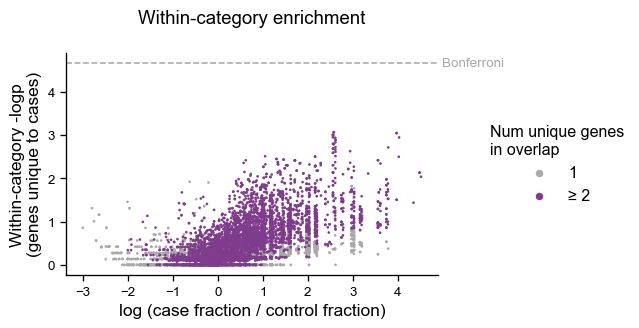

In [97]:
fig, ax = plt.subplots(1, figsize=(5, 3))

data = ewing_coding.query('num_unique_genes_in_overlap_cases_unique_binom > 0')
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_within',
        y='y_within',
        hue = 'hue_within',
        data = data[data['hue_within'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )

ax.legend(bbox_to_anchor = (1.1, 0.5), title = 'Num unique genes\nin overlap', title_fontsize = 12)

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
sns.despine(ax=ax)
ax.set_xlabel("log (case fraction / control fraction)")
ax.set_ylabel("Within-category -logp\n(genes unique to cases)")
ax.set_title("Within-category enrichment", y=1.1)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)

fig.savefig("images/ewing-coding-within-category.png", bbox_inches="tight")

In [98]:
ewing_coding.sort_values(by="y_within", ascending = False) \
[['category', 'gs', 'num_unique_genes_in_overlap_cases_fisher', 'y_within', 'x_within']].head(5)

,category,gs,num_unique_genes_in_overlap_cases_fisher,y_within,x_within
97005,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,head morphogenesis (GO:0060323),3,3.069457,2.579424
19305,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,head morphogenesis (GO:0060323),3,3.069457,2.579424
504251,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,platelet activation (GO:0030168),4,3.048760,3.976730
498701,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,platelet activation (GO:0030168),4,3.048760,3.976730
501723,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,coagulation (GO:0050817),6,3.006918,2.561693


In [99]:
sensory = ('ANY.SINGLETON.ANY.ANY.ANY.protein_coding', 
          'GO_Biological_Process_Full | detection of mechanical stimulus involved in sensory perception (GO:0050974)')

cations = ('DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding', 
            'GO_Biological_Process_Full | inorganic cation transmembrane transport (GO:0098662)')

# wnt2 = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
#         'GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)')

# protein_folding = ('DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding', 
#                    'GO_Biological_Process_Full | protein folding (GO:0006457)')

I want to take a mega biased look at just look at dosages in these genes for some large categories.

In [100]:
ref_lookups = {}
for i, gene_group in enumerate(
    [sensory, cations]
):
    
    test_cat = gene_group[0]
    related_genes = sorted(set(gene_sets[gene_group[1]]))

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "ewing")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "ewing" & sv_category == "coding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_gs = case_counts[case_counts["gene"].isin(related_genes)]
    case_gs_dosage = case_gs['dose'].sum()
    
    ref_lookups[gene_group[1]] = case_gs

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "ewing" & sv_category == "coding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_gs = control_counts[control_counts["gene"].isin(related_genes)]
    control_gs_dosage = control_gs["dose"].sum()
    
    cat_genes = category_gene_matrix.loc[test_cat]
    cat_genes = list(cat_genes[cat_genes == 1].index)
    
    print(gene_group[0])
    print(gene_group[1])
    print(case_gs_dosage, case_dosage, control_gs_dosage, control_dosage, len(set(cat_genes) & set(related_genes)), len(cat_genes))
    print(case_gs_dosage / case_dosage, control_gs_dosage / control_dosage, len(set(cat_genes) & set(related_genes)) / len(cat_genes))
    
    print(case_gs['gene'].tolist(), control_gs['gene'].tolist())
    print()


ANY.SINGLETON.ANY.ANY.ANY.protein_coding
GO_Biological_Process_Full | detection of mechanical stimulus involved in sensory perception (GO:0050974)
7 766 3 3519 35 19092
0.009138381201044387 0.0008525149190110827 0.0018332285774146238
['SCN11A', 'ADGRV1', 'ADGRV1', 'TMC1', 'CXCL12', 'CHRNA10', 'CHRNA10'] ['PIEZO2', 'PIEZO2', 'MKKS']

DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding
GO_Biological_Process_Full | inorganic cation transmembrane transport (GO:0098662)
31 517 59 2270 653 19092
0.059961315280464215 0.025991189427312777 0.03420280745862141
['SLC9A1', 'ATP5PB', 'SLC30A10', 'SLC4A7', 'SCN11A', 'CACNA2D3', 'CACNA2D3', 'SLC12A8', 'SLC9B1', 'UCP1', 'SLC25A4', 'ITPR3', 'KCNV2', 'SLC1A1', 'TMC1', 'TMEM38B', 'GRIN1', 'GHITM', 'PKD2L1', 'PKD2L1', 'CHRNA10', 'GRIK4', 'SLC4A8', 'TRPV4', 'ATP7B', 'SLC28A1', 'AQP8', 'PKD1L3', 'TRPV3', 'TRPM4', 'LARGE1'] ['RHCE', 'RHCE', 'CACHD1', 'KCNT2', 'ATP6V1C2', 'SLC4A10', 'SCN7A', 'ATP2B2', 'SCN10A', 'CACNA2D3', 'HTR3C'

### Baseline enrichment

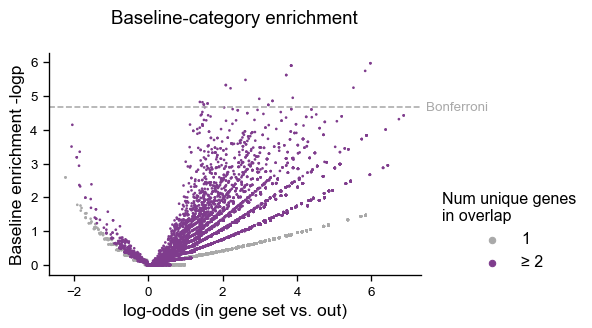

In [101]:
fig, ax = plt.subplots(1, figsize=(5, 3))

ewing_coding["x_baseline"] = np.log2(ewing_coding["odds_ratio_cases_fisher"])
ewing_coding["y_baseline"] = -np.log10(ewing_coding["p_cases_fisher"])
ewing_coding['hue_baseline'] = np.where(ewing_coding['num_unique_genes_in_overlap_cases_fisher'] > 1, '≥ 2', '1')

data = ewing_coding.query('num_unique_genes_in_overlap_cases_fisher > 0').copy()
for hue in ['1', '≥ 2']:
    
    sns.scatterplot(
        x='x_baseline',
        y='y_baseline',
        hue = 'hue_baseline',
        data = data[data['hue_baseline'] == hue],
        s=4,
        palette = palette,
        ec=None,
        ax=ax
    )
    
ax.legend(bbox_to_anchor = (1.02, 0.2), title = 'Num unique genes\nin overlap', title_fontsize = 12)

ax.axhline(
    y=-np.log10(0.05 / num_effective_tests), linestyle="dashed", color="darkgrey"
)
ax.text(
    x=ax.get_xlim()[1] * 1.02,
    y=-np.log10(0.05 / num_effective_tests),
    s="Bonferroni",
    ha="left",
    va="center",
    fontsize=10,
    color="darkgrey",
)
sns.despine(ax=ax)
ax.set_xlabel("log-odds (in gene set vs. out)")
ax.set_ylabel("Baseline enrichment -logp")
ax.set_title("Baseline-category enrichment", y=1.1)

fig.savefig("images/ewing-coding-baseline-category.png", bbox_inches="tight")

What are the categories that have synaptic transmission signal?

In [102]:
ewing_coding.sort_values(by="y_baseline", ascending = False).query('x_baseline > 0').head(20)

,disease,category,sv_category,analysis_fisher,db,gs,ref_freq_cases_fisher,cat_freq_cases_fisher,num_unique_genes_in_overlap_cases_fisher,odds_ratio_cases_fisher,p_cases_fisher,fdr_p_cases_fisher,bonf_p_cases_fisher,ref_freq_controls_fisher,cat_freq_controls_fisher,num_unique_genes_in_overlap_controls_fisher,odds_ratio_controls_fisher,p_controls_fisher,fdr_p_controls_fisher,bonf_p_controls_fisher,ref_freq_cases_unique_fisher,cat_freq_cases_unique_fisher,num_unique_genes_in_overlap_cases_unique_fisher,odds_ratio_cases_unique_fisher,p_cases_unique_fisher,fdr_p_cases_unique_fisher,bonf_p_cases_unique_fisher,expected_prop_cases_binom,observed_prop_cases_binom,p_cases_binom,fdr_p_cases_binom,bonf_p_cases_binom,num_unique_genes_in_overlap_cases_binom,expected_prop_controls_binom,observed_prop_controls_binom,p_controls_binom,fdr_p_controls_binom,bonf_p_controls_binom,num_unique_genes_in_overlap_controls_binom,expected_prop_cases_unique_binom,observed_prop_cases_unique_binom,p_cases_unique_binom,fdr_p_cases_unique_binom,bonf_p_cases_unique_binom,num_unique_genes_in_overlap_cases_unique_binom,expected_cat_baseline,data_cat_baseline,odds_ratio_cat_baseline,p_cat_baseline,fdr_p_cat_baseline,point_estimate,category_bonferroni_significant,expression,functional_category,hue_within,binom_odds_ratio,x_within,y_within,x_baseline,y_baseline,hue_baseline
18547,ewing,DEL.SINGLETON.ANY.ANY.ANY.protein_coding,coding,full,GO_Biological_Process_Full,positive regulation of synaptic transmission (GO:0050806),0/3332,6/377,6,62.717742,0.000001,0.002953,0.002462,12/19931,7/1690,7,7.279371,3.829312e-04,0.004136,0.886103,0/402,4/213,4,9.595238,0.014124,1.000000,32.683246,0.007333,0.015915,0.061361,0.978950,141.988684,6,0.007333,0.004142,0.151476,0.641736,350.516132,7,0.007333,0.018779,0.072946,1.00000,168.796340,4,140/19092,140/19092,NaN,1.000000,1.000000,0.224395,True,ANY,NaN,≥ 2,3.842365,1.941994,1.137000,5.970802,5.973100,≥ 2
96247,ewing,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.ANY.protein_coding,coding,full,GO_Biological_Process_Full,positive regulation of synaptic transmission (GO:0050806),0/3332,6/377,6,62.717742,0.000001,0.002953,0.002462,12/19931,7/1690,7,7.279371,3.829312e-04,0.004136,0.886103,0/402,4/213,4,9.595238,0.014124,1.000000,32.683246,0.007333,0.015915,0.061361,0.978950,141.988684,6,0.007333,0.004142,0.151476,0.641736,350.516132,7,0.007333,0.018779,0.072946,1.00000,168.796340,4,140/19092,140/19092,NaN,1.000000,1.000000,0.224395,True,ANY,NaN,≥ 2,3.842365,1.941994,1.137000,5.970802,5.973100,≥ 2
499563,ewing,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,coding,full,MSigDB_Hallmark_2020,Xenobiotic Metabolism,18/3584,8/125,7,14.318912,0.000001,0.001733,0.002889,192/21129,7/492,7,1.785795,2.264527e-01,0.488069,524.011487,2/537,5/78,5,14.486486,0.000498,0.276630,1.152956,0.014142,0.064000,0.000435,0.905364,1.006082,7,0.014142,0.014228,0.849337,1.000000,1965.364879,7,0.014142,0.064103,0.005083,0.88197,11.762995,5,199/19092,107/7566,1.782845,0.000056,0.000108,0.384427,True,expressed_in_muscle_skeletal,NaN,≥ 2,4.498286,2.169375,2.293845,3.839850,5.903590,≥ 2
494013,ewing,DEL.SINGLETON.PREDICTED_LOF_or_PREDICTED_PARTIAL_EXON_DUP.ANY.expressed_in_muscle_skeletal.protein_coding,coding,full,MSigDB_Hallmark_2020,Xenobiotic Metabolism,18/3584,8/125,7,14.318912,0.000001,0.001733,0.002889,192/21129,7/492,7,1.785795,2.264527e-01,0.488069,524.011487,2/537,5/78,5,14.486486,0.000498,0.276630,1.152956,0.014142,0.064000,0.000435,0.905364,1.006082,7,0.014142,0.014228,0.849337,1.000000,1965.364879,7,0.014142,0.064103,0.005083,0.88197,11.762995,5,199/19092,107/7566,1.782845,0.000056,0.000108,0.384427,True,expressed_in_muscle_skeletal,NaN,≥ 2,4.498286,2.169375,2.293845,3.839850,5.903590,≥ 2
499523,ewing,DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding,coding,full,MSigDB_Hallmark_2020,Adipogenesis,18/3584,8/125,8,14.318912,0.000001,0.001733,0.002889,144/21129,11/492,11,3.603262,8.659728e-04,0.011393,2.003861,5/5

In [104]:
adipo = ('DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 
          'MSigDB_Hallmark_2020 | Adipogenesis')

energy = ('ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding', 
           'GO_Biological_Process_Full | generation of precursor metabolites and energy (GO:0006091)')

xenobiotic_met = ('DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding',
                  'MSigDB_Hallmark_2020 | Xenobiotic Metabolism')

# wnt2 = ('DEL.SINGLETON.ANY.neuroblastoma_ABC_MAX_enhancer_conserved.ANY.ANY.ANY.protein_coding', 
#         'GO_Biological_Process_Full | regulation of Wnt signaling pathway (GO:0030111)')

# protein_folding = ('DEL.SINGLETON.ANY.neuroblastoma_tad_boundary.PREDICTED_INTERGENIC.ANY.ANY.protein_coding', 
#                    'GO_Biological_Process_Full | protein folding (GO:0006457)')

In [105]:
ref_lookups = {}
for i, gene_group in enumerate(
    [adipo, energy, xenobiotic_met]
):
    
    test_cat = gene_group[0]
    related_genes = sorted(set(gene_sets[gene_group[1]]))

    test_cat_svs = category_svs[
        (category_svs["category"] == test_cat)
        & (category_svs["disease"] == "ewing")
    ]["SV"].tolist()

    # get case counts
    case_counts = ref_counts.query(
        'disease == "ewing" & sv_category == "coding" & cohort == "case" & dose > 0'
    )
    case_counts = case_counts[(case_counts["name"].isin(test_cat_svs))]

    case_dosage = case_counts["dose"].sum()
    case_gs = case_counts[case_counts["gene"].isin(related_genes)]
    case_gs_dosage = case_gs['dose'].sum()
    
    ref_lookups[gene_group[1]] = case_gs

    # get control coutns
    control_counts = ref_counts.query(
        'disease == "ewing" & sv_category == "coding" & cohort == "control" & dose > 0'
    )
    control_counts = control_counts[(control_counts["name"].isin(test_cat_svs))]

    control_dosage = control_counts["dose"].sum()
    control_gs = control_counts[control_counts["gene"].isin(related_genes)]
    control_gs_dosage = control_gs["dose"].sum()
    
    cat_genes = category_gene_matrix.loc[test_cat]
    cat_genes = list(cat_genes[cat_genes == 1].index)
    
    print(gene_group[0])
    print(gene_group[1])
    print(case_gs_dosage, case_dosage, control_gs_dosage, control_dosage, len(set(cat_genes) & set(related_genes)), len(cat_genes))
    print(case_gs_dosage / case_dosage, control_gs_dosage / control_dosage, len(set(cat_genes) & set(related_genes)) / len(cat_genes))
    
    print(case_gs['gene'].tolist(), control_gs['gene'].tolist())
    print()


DEL.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding
MSigDB_Hallmark_2020 | Adipogenesis
9 208 15 802 166 7566
0.04326923076923077 0.018703241895261846 0.021940259053661114
['ELMOD3', 'REEP5', 'CD36', 'GHITM', 'SNCG', 'CHUK', 'DHRS7', 'ACOX1', 'SAMM50'] ['AK2', 'HIBCH', 'MCCC1', 'ADIPOQ', 'ME1', 'CD36', 'FABP4', 'ITIH5', 'VEGFB', 'SSPN', 'ALDOA', 'PEMT', 'LIPE', 'BCL2L13', 'TST']

ANY.SINGLETON.ANY.ANY.expressed_in_muscle_skeletal.protein_coding
GO_Biological_Process_Full | generation of precursor metabolites and energy (GO:0006091)
17 351 35 1469 258 7566
0.04843304843304843 0.023825731790333562 0.03409992069785884
['NDUFS5', 'ATP5PB', 'DGUOK', 'PER2', 'SUCLG2', 'SLC25A4', 'LYRM7', 'SLC25A13', 'GSR', 'ASPH', 'ASPH', 'FXN', 'PFKP', 'NDUFC2', 'PHKB', 'ACOX1', 'ME2'] ['ALDH4A1', 'AKR7A3', 'POMC', 'GFPT1', 'DGUOK', 'GYG1', 'ADIPOQ', 'NDUFC1', 'ETFDH', 'SDHA', 'ME1', 'OGDH', 'FXN', 'PFKP', 'DHTKD1', 'NDUFV1', 'DERA', 'DNAJC15', 'DNAJC15', 'DNAJC15', 'OXA1L', 'PYGL', 'ETFA', 'W